# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [16]:
# Imports here
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch import nn, optim
import torch.nn.functional as F
import torch
import random
from os import listdir, path
from tqdm import tqdm
from collections import OrderedDict
import json
from tempfile import TemporaryDirectory


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]),
    ])
valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]),
])

                                                            

#Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True)
valid_dataloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=64, shuffle=True)
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


Text(0.5, 1.0, '77')

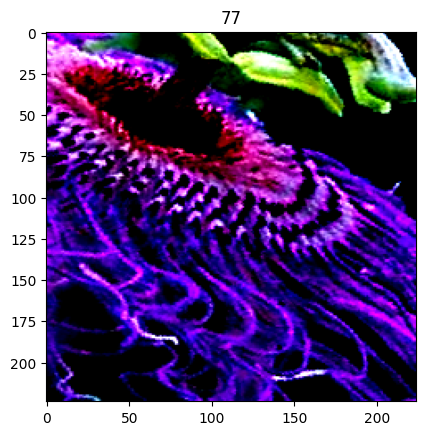

In [4]:
# Check out the data
images, labels = next(iter(train_dataloaders))
print(type(images))
print(images.shape)
print(labels.shape)
# plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')
# util.imshow(images[0])
select_idx = random.randint(0, len(images)-1)
plt.imshow(images[select_idx].numpy().transpose((1, 2, 0)))
plt.title(labels[select_idx].item())



### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
# load label mapping from json file
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
#: Build and train your network

def build_from_pretrained(arch = 'vgg19', input_size = 4096, output_size = 102, hidden_units = [4096, 500], drop_p = 0.5):
    # dict of models that can be used in this project
    model_dict = {
        'vgg19': 'classifier',
        'resnet50': 'fc',
        'inception_v3': 'fc',
        'resnext101_32x8d': 'fc',
    }


    # Load a pre-trained network
    # arch = 'vgg19'
    if model_dict.get(arch) is None:
        print(f'Error: {arch} is not a supported model architecture')
        # print the valid model names
        print('Currently supported model architectures are:')
        for key in model_dict.keys():
            print(key)
        # select a default valid model name
        arch = list(model_dict.keys())[0]
        print(f'Using {arch} as the default model architecture')


    model = models.get_model(arch, pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    # pass the classifer layer and other input arguments as attribute to the model to use it later
    # save the input params 
    extras = {
        'arch': arch,
        'input_size': input_size,
        'output_size': output_size,
        'hidden_units': hidden_units,
        'drop_p': drop_p,
        'classifier_layer': model_dict[arch],
    }
    # add the extras as attribute to the model to use it later in checkpoints
    model.extras = extras
    

    # get the input size of the classifier from the pretrained model
    # print(f'Input size of the classifier is {model_dict[arch]} {') 
    # get classifier layer
    classifier_layer = getattr(model, model_dict[arch])
    # check if the classifier layer is a sequential layer or Linear layer
    # if it is a sequential layer then get the input size of the first layer
    # if it is a Linear layer then get the input size of the layer
    if isinstance(classifier_layer, nn.Sequential):
        model_classifier_input_size = classifier_layer[0].in_features
    elif isinstance(classifier_layer, nn.Linear): 
        model_classifier_input_size = classifier_layer.in_features
    # check if the input size is the same as the input size of the classifier otherwise print a error
    # and select the model input size as the input size of the classifier
    # if model_classifier_input_size != input_size:
    #     print(f'Error: The input size of the classifier is {model_classifier_input_size} but the input size you specified is {input_size}')
    #     print(f'Using {model_classifier_input_size} as the input size of the classifier to avoid errors')
    #     input_size = model_classifier_input_size

    # Build a feed-forward classifier network for arbitrary number of hidden layers
    # add interface layer to avoid  errors when input size is not the same as the input size of the original model classifier
    classifier = nn.Sequential(OrderedDict([
        ('interface', nn.Linear( model_classifier_input_size, input_size)),
        ('relu_interface', nn.ReLU()),
        ('dropout_interface', nn.Dropout(p=drop_p)),
        ('input',nn.Linear(input_size, hidden_units[0])),
        ('relu0',nn.ReLU()),
        ('dropout0',nn.Dropout(p=drop_p)),
    ])
    )
    # add hidden layers
    for i in range(len(hidden_units)-1):
        classifier.add_module(f'fc{i+1}', nn.Linear(hidden_units[i], hidden_units[i+1]))
        classifier.add_module(f'relu{i+1}', nn.ReLU())
        classifier.add_module(f'dropout{i+1}', nn.Dropout(p=0.2))


    # add output layer
    classifier.add_module('output',nn.Linear(hidden_units[-1], output_size))
    classifier.add_module('logps',nn.LogSoftmax(dim=1))
    
    # print(model)
    # replace the classifier in the model
    setattr(model, model_dict[arch], classifier)
    # # remove the classifier or fc layer in the model
    # delattr(model, model_dict[arch])

    return model

# call the function to check if it works
# model = build_from_pretrained(arch= 'resnext101_32x8d')
# model


In [7]:
# # define untrained classifier network with 102 output 
# 
# classifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(4096, 500)),
#                           ('relu', nn.ReLU()),
#                           ('dropout', nn.Dropout(p=0.2)),
#                           ('fc2', nn.Linear(500, 102)),
#                           ('output', nn.LogSoftmax(dim=1))
#                           ]))



# build pretrained model by calling the build_from_pretrained function
model = build_from_pretrained(arch= 'vgg19', input_size = 4096, output_size=102, hidden_units=[2048, 1024, 512], drop_p=0.2)
print("classifier layer for the model: \n", model.extras['classifier_layer'], ": ")
model.get_submodule(model.extras['classifier_layer'])

/Users/ashraful/CodingWorkspace/Udacity/AIProgrammingWPython/udacity_project_train_image_classifier/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ashraful/CodingWorkspace/Udacity/AIProgrammingWPython/udacity_project_train_image_classifier/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


classifier layer for the model: 
 classifier : 


Sequential(
  (interface): Linear(in_features=25088, out_features=4096, bias=True)
  (relu_interface): ReLU()
  (dropout_interface): Dropout(p=0.2, inplace=False)
  (input): Linear(in_features=4096, out_features=2048, bias=True)
  (relu0): ReLU()
  (dropout0): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=512, out_features=102, bias=True)
  (logps): LogSoftmax(dim=1)
)

In [8]:
## Training the network

# create a temporary directory to save the best model checkpoints to restore when early stopping
# Create a temporary directory to save training checkpoints
with TemporaryDirectory() as tempdir:
    best_weights = path.join(tempdir, 'best_weights.pt')

#save the current weights as the best weights before training
torch.save(model.state_dict(), best_weights)

# device setting for GPU on Mac with Apple M2 chip

# select GPU if available else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found. Switching to MPS.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found. Switching to GPU.")
else:
    print ("MPS device not found. Switching to CPU.")
    device = torch.device("cpu")

# define loss function and optimizer
criterion = nn.NLLLoss()

# only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.get_submodule(model.extras['classifier_layer']).parameters(), lr=0.001)

# move model to device
model.to(device)
# optimizer.to(device)

# train the network
epochs = 50
prev_loss = 1000.
prev_valid_loss = 1000.
prev_accuracy = 0.
best_valid_loss = 1000.


#parameters for early stopping
epochs_no_improve = 0
max_epochs_stop = 5


arrow_up = '\u2191'
arrow_down = '\u2193'


for epoch in range(epochs):

    # turn on training mode
    model.train()
    running_loss = 0
    steps = 0
    # progress_bar = tqdm(total=len(train_dataloaders), leave=False)
    for images, labels in train_dataloaders:
        steps += 1
        # print(images.shape)
        # images = images.view(images.shape[0], 3, -1)
        # move images and labels to device
        images, labels = images.to(device), labels.to(device)
        
        # train
        optimizer.zero_grad()
        logps = model.forward(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # update the progress bar
        # progress_bar.update(1)
        #print progress batch
        print(f'Processing training batch: {steps}/{len(train_dataloaders)}', end='\r')

        # if steps % 5 == 0:
        #     print(f"Training loss for {steps}/{len(train_dataloaders)} steps: {running_loss/steps}")
    
    # else:
    # print training loss for each epoch and print up/down if the loss is increasing or decreasing
    print(f"Training loss for epoch {epoch+1}/{epochs}: {running_loss/len(train_dataloaders):.5f} {arrow_up if prev_loss < running_loss else arrow_down}")
    prev_loss = running_loss
    # close the progress bar
    # progress_bar.close()

    ##################################
    # validate the network every epoch to check if the model is overfitting
    # stop training if the validation loss does not improve for max_epochs_stop times
    # if epoch % 5 == 0:
    valid_loss = 0
    accuracy = 0
    steps = 0
    model.eval()
    with torch.no_grad():
        # progress bar for validation
        # progress_bar = tqdm(total=len(valid_dataloaders), leave=False)

        for images, labels in valid_dataloaders:
            steps += 1
            images, labels = images.to(device), labels.to(device)
            logps = model.forward(images)
            loss = criterion(logps, labels)
            valid_loss += loss.item()

            # calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # update the progress bar
            # progress_bar.update(1)
            print(f'Processing validation batch: {steps}/{len(valid_dataloaders)}', end='\r')
    
    # print validation loss and accuracy, also print up/down arrow if the loss/accuracy is increasing or decreasing
    print(f"Validation loss for epoch {epoch+1}/{epochs}: {valid_loss/len(valid_dataloaders):.5f} {arrow_up if prev_valid_loss < valid_loss else arrow_down}")
    print(f"Accuracy for epoch {epoch+1}/{epochs}: {100*accuracy/len(valid_dataloaders):.2f}% {arrow_up if prev_accuracy < accuracy else arrow_down}")
    print("--------------------------------------------------")
    # update the previous loss and accuracy
    prev_valid_loss = valid_loss
    prev_accuracy = accuracy
    # close the progress bar
    # progress_bar.close()

    # early stopping
    if valid_loss < best_valid_loss:
        epochs_no_improve = 0
        best_valid_loss = valid_loss
        # save the best model weights
        torch.save(model.state_dict(), best_weights)
    else:
        epochs_no_improve += 1

        

    if epochs_no_improve == max_epochs_stop:
        print(f'Early stopping since validation loss did not improve for {max_epochs_stop} epochs.')
        # load the best model weights
        model.load_state_dict(torch.load(best_weights))
        break

    



MPS device found. Switching to MPS.
Training loss for epoch 1/30: 3.81459 ↓
Validation loss for epoch 1/30: 2.51954 ↓
Accuracy for epoch 1/30: 34.76% ↑
--------------------------------------------------
Training loss for epoch 2/30: 2.47933 ↓
Validation loss for epoch 2/30: 1.79635 ↓
Accuracy for epoch 2/30: 49.67% ↑
--------------------------------------------------
Training loss for epoch 3/30: 1.94544 ↓
Validation loss for epoch 3/30: 1.34988 ↓
Accuracy for epoch 3/30: 61.79% ↑
--------------------------------------------------
Training loss for epoch 4/30: 1.67831 ↓
Validation loss for epoch 4/30: 1.28974 ↓
Accuracy for epoch 4/30: 66.60% ↑
--------------------------------------------------
Training loss for epoch 5/30: 1.50848 ↓
Validation loss for epoch 5/30: 1.04906 ↓
Accuracy for epoch 5/30: 72.75% ↑
--------------------------------------------------
Training loss for epoch 6/30: 1.40837 ↓
Validation loss for epoch 6/30: 0.87384 ↓
Accuracy for epoch 6/30: 75.97% ↑
-------------

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# Do test on the test dataset
# put model to device mode
model.to(device)
model.eval()
test_loss = 0
accuracy = 0
steps = 0

with torch.no_grad():
    for images, labels in test_dataloaders:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        logps = model.forward(images)
        loss = criterion(logps, labels)
        test_loss += loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_ps, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        #print progress batch
        print(f'Processing test batch: {steps}/{len(test_dataloaders)}', end='\r')


    print(f"Test loss: {test_loss/len(test_dataloaders)}")
    print(f"Accuracy: {accuracy/len(test_dataloaders)}")
        

Test loss: 0.6351121205549973
Accuracy: 0.8419117652452909


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
# TODO: Save the checkpoint
model.extras['class_to_idx'] = train_datasets.class_to_idx

checkpoint = {
    'model_extras': model.extras,
    'state_dict': model.state_dict(),
    'epochs': epoch,
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'checkpoint.pth')



## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    """
    Loads a checkpoint and rebuilds the model
    Input: filepath to the checkpoint
    Output: model, epoch, optimizer
    """

    checkpoint = torch.load(filepath)
    
    # load the checkpoint extras
    model_extras = checkpoint.get('model_extras')
    if model_extras is None:
        raise Exception("The checkpoint file does not contain the information needed to rebuild the model")
    
    # print(model_extras)
    
    # if it contains the information needed to rebuild the model, then rebuild the model
    # since we are loading the model from a checkpoint if any of the model_extras are not provided
    # then the rebuild will fail
    arch = model_extras.get('arch')
    input_size = model_extras.get('input_size')
    output_size = model_extras.get('output_size')
    hidden_units = model_extras.get('hidden_units')
    drop_p = model_extras.get('drop_p')

    # check if any of values are None
    if None in [arch, input_size, output_size, hidden_units, drop_p]:
        # print which values are None
        # print(f"arch: {arch}, input_size: {input_size}, output_size: {output_size}, hidden_units: {hidden_units}, drop_p: {drop_p}")
        raise Exception("The checkpoint file does not contain the information needed to rebuild the model")

    # rebuild the model
    model = build_from_pretrained(
        arch=arch,
        input_size=input_size,
        output_size=output_size,
        hidden_units=hidden_units,
        drop_p= drop_p
        )
    
    # load the class to idx mapping
    model.extras['class_to_idx'] = model_extras.get('class_to_idx')
    # load the model state dict (weights and biases) and the optimizer state dict
    model.load_state_dict(checkpoint.get('state_dict'))
    epoch = checkpoint.get('epochs')
    optimizer.load_state_dict(checkpoint.get('optimizer_state_dict'))

    return model, optimizer, epoch


# check the load_checkpoint function
# model, optimizer, epoch = load_checkpoint('checkpoint.pth')
# print(model.get_submodule(model.extras['classifier_layer']))



# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    with Image.open(image) as im:
        # resize the image keeping the shorter side 256 pixels
        width, height = im.size
        if width > height:
            im.thumbnail((10000, 256))
        else:
            im.thumbnail((256, 10000))
        
        # center crop the image to 224x224 pixels
        width, height = im.size
        left = (width - 224)/2
        top = (height - 224)/2
        right = (width + 224)/2
        bottom = (height + 224)/2
        im = im.crop((left, top, right, bottom))

        # convert image to numpy array
        np_image = np.array(im)
        # convert to 0-1 scale from 0-255
        np_image = np_image/255
        # normalize the image with means [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225]
        np_image = (np_image - [0.485, 0.456, 0.406])/[0.229, 0.224, 0.225]
        # transpose the image so the color channel is the first dimension
        np_image = np_image.transpose((2, 0, 1))
        return np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
def predict(image_path, checkpoint_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        "Uses the cpu for inference by default"
        Input: image_path: path to the image
                checkpoint_path: the model to use for prediction
                topk: the number of top classes to return
        Output: top_p: the top probabilities for the classes
                top_class: the top classes
        
    '''

    # select the device to use for inference (select cpu by default since its a one shot inference)
    device = torch.device("cpu")
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)

    # convert numpy array to tensor
    image = torch.from_numpy(image).type(torch.FloatTensor)
    # check if converion worked
    # imshow(image)

    # add batch of size 1 to image
    # image.unsqueeze_(0)
    image = image.view(1, image.shape[0], image.shape[1], image.shape[2])

    # move the image to the device (GPU or CPU)
    image = image.to(device)



    # load the model from the checkpoint
    model, _, _ = load_checkpoint(checkpoint_path)
    # move the model to the device (GPU or CPU)
    model = model.to(device)

    # evaluate the image using the model
    model.eval()

    # invert the class_to_idx dictionary
    idx_to_class = {v: k for k, v in model.extras.get('class_to_idx').items()}
    
    
    with torch.no_grad():
        
        ps = torch.exp(model.forward(image))
        top_ps, top_class = ps.topk(topk, dim=1)

        # convert the tensors to numpy arrays
        top_ps = top_ps[0].numpy()
        top_class = top_class[0].numpy()
        top_ps_list = top_ps.tolist()
        # use the classes to get the class keys
        top_class_keys = [idx_to_class[i.item()] for i in top_class]

        return top_ps_list, top_class_keys

        



## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

[0.25094306468963623, 0.19952648878097534, 0.18636281788349152, 0.06855456531047821, 0.04367132857441902]
['53', '45', '51', '3', '98']
['primula', 'bolero deep blue', 'petunia', 'canterbury bells', 'mexican petunia']


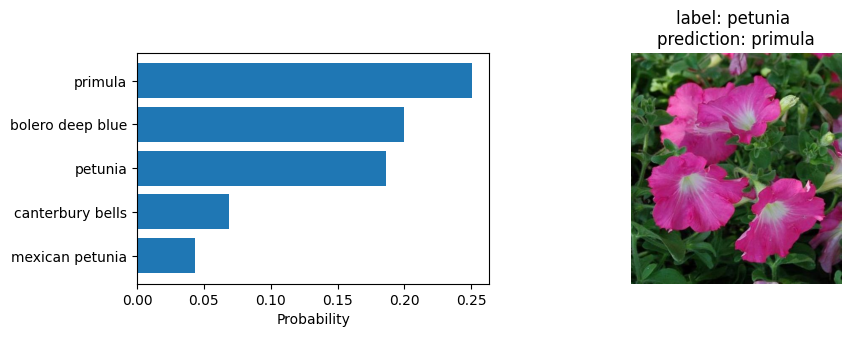

In [15]:


# TODO: Display an image along with the top 5 classes
# select a random image from the test dataset
image_data_dir = test_dir
image_label = random.choice(listdir(image_data_dir))
image_dir = image_data_dir + '/' + image_label 
image_path = image_dir + '/' + random.choice(listdir(image_dir))
# print(image_label, image_path)

# checkpoint path
checkpoint_path = 'checkpoint.pth'


probs, classes = predict(image_path=image_path, checkpoint_path=checkpoint_path, topk=5)
# load the label 

print(probs)
print(classes)

# use the class keys to get the class names and print
top_class_names = [cat_to_name[i] for i in classes]
print(top_class_names)

# plot a bar graph with top 5 classes and their probabilities
plt.figure(figsize=(10, 3))
# plot the image
plt.subplot(1, 2, 2)
plt.imshow(Image.open(image_path))
plt.title("label: {} \nprediction: {}".format(cat_to_name.get('{}'.format(image_label)), top_class_names[0]))
plt.axis('off')

# plot the probabilities
plt.subplot(1, 2, 1)

# get indexes in reversed order to chart highest probability first
idx = len(top_class_names) - np.arange(len(top_class_names))

plt.barh(idx, probs)
plt.yticks(idx, top_class_names)
plt.xlabel('Probability')
plt.show()

